<h1 align='center'> Titanic </h1>


**Variable Description**
- PassengerId: unique id number to each passanger
- Survived: passenger survive(1) or died(0)       [**Dependent variable**]
- Pclass: passenger class
- Name: name
- Sex: gender of passenger
- Age: age of passenger
- SibSp: number of siblings/spouses
- Parch: number of parents/children
- Ticket: ticket number
- Fare: amount of money for ticket
- Cabin: cabin category
- Embarked: port where passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton)



https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8

### Importing all libraries

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression,Perceptron,SGDClassifier
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.metrics import confusion_matrix,plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

### Reading data and exploration

In [2]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From this we can notice that around **38%** of all the ppl in training data survived, also we can see that the Age attribute has some missing values.
___
Lets look into the missing values in detail

In [6]:
total_null=train_df.isnull().sum().sort_values(ascending=False)
total_null

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [7]:
percent_null1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_null2 = (round(percent_null1, 1)).sort_values(ascending=False)
percent_null2

Cabin          77.1
Age            19.9
Embarked        0.2
Fare            0.0
Ticket          0.0
Parch           0.0
SibSp           0.0
Sex             0.0
Name            0.0
Pclass          0.0
Survived        0.0
PassengerId     0.0
dtype: float64

In [8]:
null_val = pd.concat([total_null,percent_null2],axis=1,keys=['null_cnt','%age null'])
null_val.head()

,null_cnt,%age null
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


### Data Preprocessing

lets remove the passengerID column from the training data since it does not have any relevence in our model

In [9]:
train_df.drop('PassengerId', axis=1,inplace=True)

In [10]:
#example of compile function
import re
re.compile("([a-zA-Z]+)").search('A65465').group()

'A'

### Missing Data

**1)Cabin**

We have to deal with 687 null values of cabin.
A cabin number looks like ‘C123’ and the letter refers to the deck. Therefore we’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero

In [11]:
#deriving a new column deck from the cabin column
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

In [12]:
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,S,8
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U0,S,8
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U0,S,8
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,U0,S,8
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,2
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,U0,S,8
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3


In [13]:
# now we can drop the Cabin attribute from both test& train dataset

train_df.drop(['Cabin'], axis=1,inplace = True)
test_df.drop(['Cabin'], axis=1,inplace = True)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  889 non-null    object 
 10  Deck      891 non-null    int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 73.2+ KB


**2)Age**

There are 177 null values in Age column of train data,lets fill them up randomly ranging from **mean-std** to **mean+std**

In [15]:
for dataset in data:
    mean = dataset['Age'].mean()
    std = dataset['Age'].std()
    null_cnt = dataset['Age'].isnull().sum()
    #generate random age between 1-SD of mean of age.
    age_rand = np.random.randint(mean-std,mean+std,size = null_cnt)
    #now fill these random ages in place of null values
    age_slice = dataset['Age'].copy()
    age_slice[np.isnan(age_slice)] = age_rand
    dataset['Age'] = age_slice
    dataset['Age'] = dataset['Age'].astype(int)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  889 non-null    object 
 10  Deck      891 non-null    int32  
dtypes: float64(1), int32(2), int64(4), object(4)
memory usage: 69.7+ KB


**3)Embarked**

In [17]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.

In [18]:
common_value = 'S'

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    int32  
dtypes: float64(1), int32(2), int64(4), object(4)
memory usage: 69.7+ KB


Now we can see there are no null values in train data,just to confirm

In [20]:
train_df.isnull().values.sum()

0

train_df

In [21]:
train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,8
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,3
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,8
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,3
4,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,8
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.0000,S,8
887,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.0000,S,2
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,36,1,2,W./C. 6607,23.4500,S,8
889,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.0000,C,3


In [22]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

The Ticket attribute has 681 unique values ,hence it can be dropped since it may not be able to impact the dependent variable

In [23]:
train_df.drop('Ticket',axis=1,inplace=True)
test_df.drop('Ticket',axis=1,inplace=True)

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
 9   Deck      891 non-null    int32  
dtypes: float64(1), int32(2), int64(4), object(3)
memory usage: 62.8+ KB


### Converting objects to int / float to int

We have to deal with 3 categorical features: Name, Sex and Embarked. Lets investigate and transfrom one after another.

**1)Sex**

In [25]:
train_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [26]:
sex = {'male':0, 'female':1}

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(sex)

In [27]:
train_df['Sex'].unique()

array([0, 1], dtype=int64)

**2)Embarked**

embarked (C = Cherbourg, Q = Queenstown, S = Southampton)

In [28]:
train_df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [29]:
embark = {'S':0, 'C':1, 'Q':2}

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(embark)

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    int64  
 4   Age       891 non-null    int32  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    int64  
 9   Deck      891 non-null    int32  
dtypes: float64(1), int32(2), int64(6), object(1)
memory usage: 62.8+ KB


**3)Name**

Lets derive a new column title from name ,we can drop the name column once done

In [31]:
train_df.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [32]:
train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

let's categorise the unique title into groups
- Mr
- Master
- Miss (Miss,Ms,Mlle)
- Mrs (Mrs,Mme)
- Special (Don,Rev,Dr,Major,Lady,Sir,Col,Capt,Countess,Jonkheer,Dona)

In [33]:
title = {'Mr': 1, 'Master': 2, 'Miss': 3,'Mrs': 4, 'Special': 5}

for dataset in data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Ms','Mlle'],'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    dataset['Title'] = dataset['Title'].replace(['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'],'Special')
    
    dataset['Title'] = dataset['Title'].map(title)
    dataset['Title'] = dataset['Title'].fillna(0)
    

In [34]:
train_df['Title'].unique()

array([1, 4, 3, 2, 5], dtype=int64)

In [35]:
test_df['Title'].unique()

array([1, 4, 3, 2, 5], dtype=int64)

In [36]:
#drop the name columns
train_df.drop('Name',axis=1,inplace=True)
test_df.drop('Name',axis=1,inplace=True)

In [37]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    int32  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
 8   Deck      891 non-null    int32  
 9   Title     891 non-null    int64  
dtypes: float64(1), int32(2), int64(7)
memory usage: 62.8 KB


**4)Fare**

let covert fare to int

In [38]:
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int32
 4   SibSp     891 non-null    int64
 5   Parch     891 non-null    int64
 6   Fare      891 non-null    int32
 7   Embarked  891 non-null    int64
 8   Deck      891 non-null    int32
 9   Title     891 non-null    int64
dtypes: int32(3), int64(7)
memory usage: 59.3 KB


In [40]:
train_df.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.735129,0.523008,0.381594,31.785634,0.361392,6.936027,1.987654
std,0.486592,0.836071,0.477990,13.490383,1.102743,0.806057,49.703730,0.635673,2.074282,1.259956
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.000000,0.000000,8.000000,1.000000
50%,0.000000,3.000000,0.000000,29.000000,0.000000,0.000000,14.000000,0.000000,8.000000,1.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000,8.000000,3.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.000000,2.000000,8.000000,5.000000


In [41]:
train_df.corr().loc[['Survived']].round(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
Survived,1.0,-0.34,0.54,-0.08,-0.04,0.08,0.26,0.11,-0.29,0.51


## ML models

## I)Logistic Regression

In [42]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [43]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,Y_train)
Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

In [44]:
acc_log

80.47

In [45]:
predictions = cross_val_predict(logreg, X_train, Y_train, cv=3)
cm = confusion_matrix(Y_train, predictions)
cm

array([[469,  80],
       [103, 239]], dtype=int64)

In [46]:
cm_df = pd.DataFrame(cm,
                     index=[i for i in ['1','0']],
                     columns=[i for i in ['Predict 1','Predict 0']])

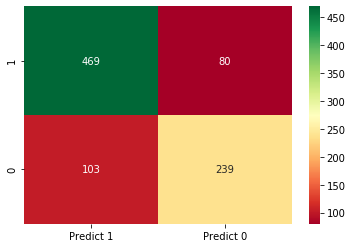

In [47]:
sns.heatmap(cm_df, annot=True,fmt='.3g',cmap='RdYlGn')

In [48]:
tp = 467
tn = 238
fp = 104
fn = 82

In [49]:
cm_df

,Predict 1,Predict 0
1,469,80
0,103,239


In [50]:
#accuracy
acc = (tn+tp) / (tp+tn+fp+fn)
acc *100

79.12457912457911

In [51]:
#recall
recall = tp / (tp+fn)
recall *100

85.06375227686704

In [52]:
#precision
pres = tp / (tp+fp)
pres*100

81.78633975481611

In [53]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,892,3,0,34,0,0,7,2,8,1
1,893,3,1,47,1,0,7,0,8,4
2,894,2,0,62,0,0,9,2,8,1
3,895,3,0,27,0,0,8,0,8,1
4,896,3,1,22,1,1,12,0,8,4


In [55]:
Y_pred.shape

(418,)

In [60]:
test_df_pred = test_df[['PassengerId']].copy()

In [61]:
test_df_pred

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [62]:
test_df_pred['Survived'] = Y_pred

In [65]:
sum(test_df_pred['Survived'] == 1)

156

In [66]:
sum(test_df_pred['Survived'] == 0)

262

In [67]:
test_df_pred.to_csv('test_df_pred.csv', index=False)

## II)Random Forest

In [68]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

97.87

In [74]:
len(Y_prediction)

418

In [72]:
test_df_rf = test_df_pred[['PassengerId']].copy()

In [75]:
test_df_rf['Survived'] = Y_prediction

In [76]:
test_df_rf

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,1
415,1307,0
416,1308,0


In [77]:
sum(test_df_rf['Survived'] == 1)

168

In [78]:
test_df_rf.to_csv('test_df_rf_pred.csv', index=False)